# Example of using litstudy

This notebook shows an example of how to use `litstudy` from inside a Jupyter notebook. It shows how to load a dataset, plot statistics, perform topic modeling, do network analysis, and some more advanced features.

This notebook focuses on the topic of programming model for GPUs. GPUs (Graphic Processing Units) are specialized processors that are used in many data centers and supercomputers for data processing and machine learning. However, programming these devices remaining difficult, which is why there is a plethora of research on developing programming models for GPUs.

In [1]:
!pip install litstudy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.5/45.5 kB 3.1 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.6/55.6 kB 3.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.3/81.3 kB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.3/77.3 kB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 756.0/756.0 kB 29.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.5/235.5 kB 15.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 59.4 MB/s eta 0:00:00
  Created wheel for litstudy: filename=litstudy-1.0.6-py3-none-any.whl size=50024 sha256=620c2ec94d326353d8b3c4dc56f68f445e73e65c7d3fd99f8815f998da88947a
  Stored in directory: /root/.cache/pip/wheels/72/97/1c/6327aca77228b1caa7

## Imports

In [2]:
# Import other libraries
import pickle
import matplotlib.pyplot as plt
import seaborn as sbs
import litstudy

# Options for plots
plt.rcParams['figure.figsize'] = (10, 6)
sbs.set('paper')

In [11]:
import logging
logging.getLogger().setLevel(logging.CRITICAL)

## Collecting the dataset

For this example, we have queried both IEEE Xplore and Springer Link for `"GPU" and "programming model"`. IEEE Xplore gives 5 CSV files (1 per page) and Springer Link gives a single CSV file. We load all files document sets and merge the resulting document sets.

In [ ]:
# Load the CSV files
docs1 = litstudy.load_ieee_csv('data/ieee_1.csv')
docs2 = litstudy.load_ieee_csv('data/ieee_2.csv')
docs3 = litstudy.load_ieee_csv('data/ieee_3.csv')
docs4 = litstudy.load_ieee_csv('data/ieee_4.csv')
docs5 = litstudy.load_ieee_csv('data/ieee_5.csv')
docs_ieee = docs1 | docs2 | docs3 | docs4 | docs5

import glob

csv_files = glob.glob('data/more_ieee_exports/*.csv')
for file in csv_files:
    more_ieee_docs = litstudy.load_ieee_csv(file)
    docs_ieee = docs_ieee | more_ieee_docs # Combine the current docs with the existing docs_ieee set

print(len(docs_ieee), 'papers loaded from IEEE')

docs_springer = litstudy.load_springer_csv('data/springer.csv')
print(len(docs_springer), 'papers loaded from Springer')

# Merge the two document sets
docs_csv = docs_ieee | docs_springer
print(len(docs_csv), 'papers loaded from CSV')

26311 papers loaded from IEEE
1000 papers loaded from Springer
27311 papers loaded from CSV


We can also exclude some papers that we are not interested in. Here, we load a document set from a RIS file and subtract these documents from our original document set.

In [ ]:
docs_exclude = litstudy.load_ris_file('data/exclude.ris')
docs_remaining = docs_csv - docs_exclude

print(len(docs_exclude), 'papers were excluded')
print(len(docs_remaining), 'paper remaining')

1 papers were excluded
27310 paper remaining


Save remaining docs

In [ ]:
# Save the docs
with open('data/docs_remaining.pkl', 'wb') as f:
    pickle.dump(docs_remaining, f)
    print(len(docs_remaining), 'papers saved in pickle')

Load docs if available

In [3]:
# Load the docs
with open('data/docs_remaining.pkl', 'rb') as f:
    docs_remaining = pickle.load(f)
    print(len(docs_remaining), 'papers loaded from pickle')

27310 papers loaded from pickle


The amount metadata provided by the CSV files is minimal. To enhance the metadata, we can find the corresponding articles on Scopus using `refine_scopus`. This function returns two sets: the set of documents that were found on Scopus and the set of original documents not were not found. We have two options on how to handle these two sets: (1) merge the two sets back into one set or (2) discard the documents that were not found. We chose the second option here for simplicity.

In [ ]:
import logging
logging.getLogger().setLevel(logging.CRITICAL)

docs_crossref, docs_notfound = litstudy.refine_crossref(docs_remaining)

print()
print(len(docs_crossref), 'papers found on CrossRef')
print(len(docs_notfound), 'papers were not found and were discarded')

 17%|█▋        | 4542/27310 [41:27<3:50:55,  1.64it/s]/usr/local/lib/python3.10/dist-packages/litstudy/sources/crossref.py:183: DeprecationWarning: The 'warn' function is deprecated, use 'warning' instead
  logging.warn(f"failed to retrieve {doi}: resource not found")
100%|██████████| 27310/27310 [4:15:47<00:00,  1.78it/s] 


26917 papers found on CrossRef
393 papers were not found and were discarded


Save crossref files in a file, to reuse them later

In [ ]:
# Save the docs crossref
with open('data/docs_crossref.pkl', 'wb') as f:
    pickle.dump(docs_crossref, f)
    print(len(docs_crossref), 'papers saved in pickle')

If you have the crossref docs, reuse them by loading from file

In [4]:
# Load the docs crossref
with open('data/docs_crossref.pkl', 'rb') as f:
    docs_crossref = pickle.load(f)
    print(len(docs_crossref), 'papers loaded from pickle')

26917 papers loaded from pickle


In [ ]:
# # api key doesn't work, so don't run this

# import pybliometrics
# pybliometrics.scopus.init()


# docs_scopus, docs_notfound = litstudy.refine_scopus(docs_remaining)

# print()
# print(len(docs_scopus), 'papers found on Scopus')
# print(len(docs_notfound), 'papers were not found and were discarded')

Next, we plot the number of documents per publication source.

In [ ]:
# # only works with docs_scopus

# # litstudy.plot_year_histogram(docs_scopus);

In this example, we discover that one document was published in 1997. This document should not be in our set since GPUs were not used for general purpose computing before 2006. We can remove this document by filtering on year of publication.

In [5]:
docs = docs_remaining.filter_docs(lambda d: d.publication_year >= 2000)

Print how many papers are left

In [6]:
print(len(docs), 'papers remaining')

27309 papers remaining


## General statistics

litstudy supports plot many general statistics of the document set as histograms. We show some simple examples below.

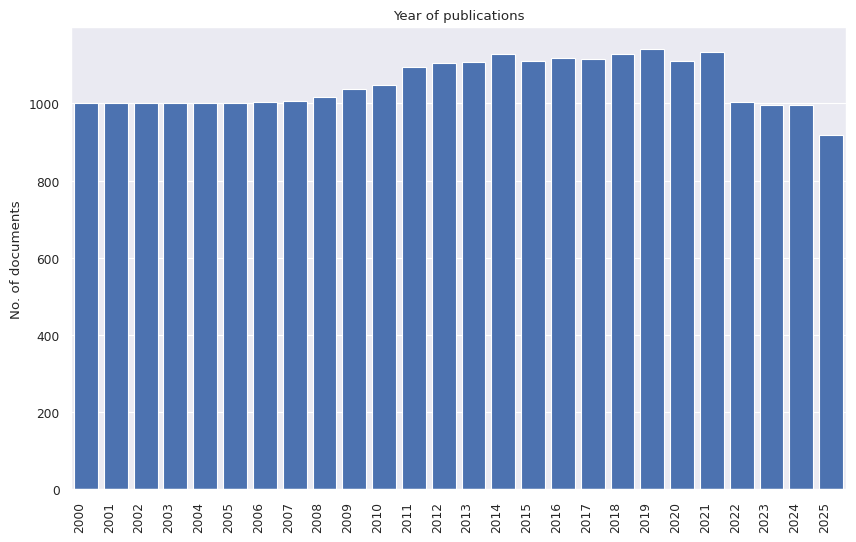

In [7]:
litstudy.plot_year_histogram(docs, vertical=True);

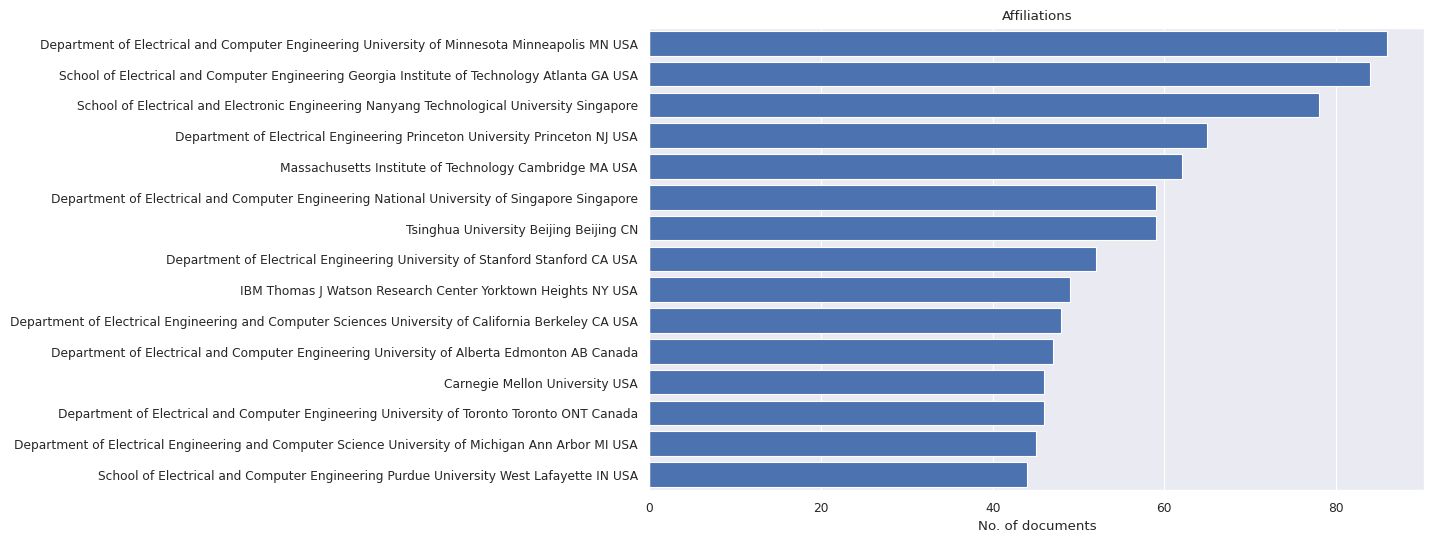

In [12]:
litstudy.plot_affiliation_histogram(docs, limit=15);

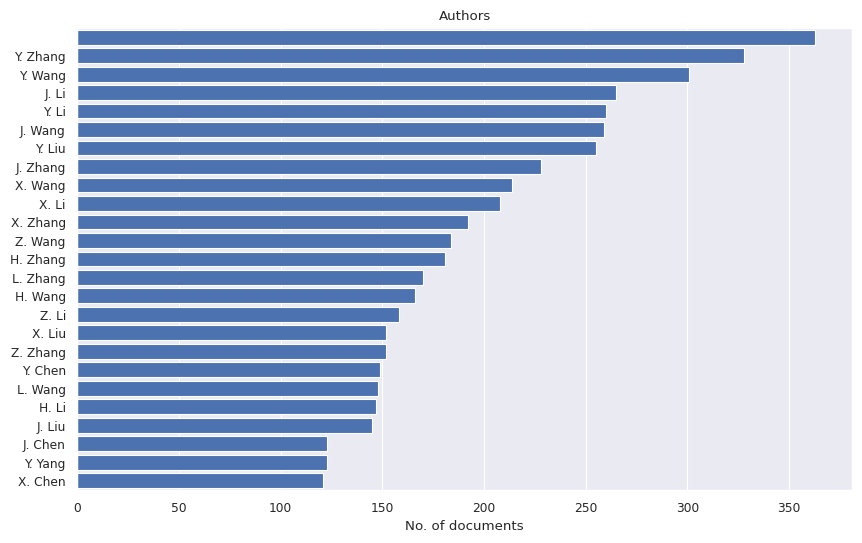

In [13]:
litstudy.plot_author_histogram(docs);

In [ ]:
# litstudy.plot_language_histogram(docs);

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


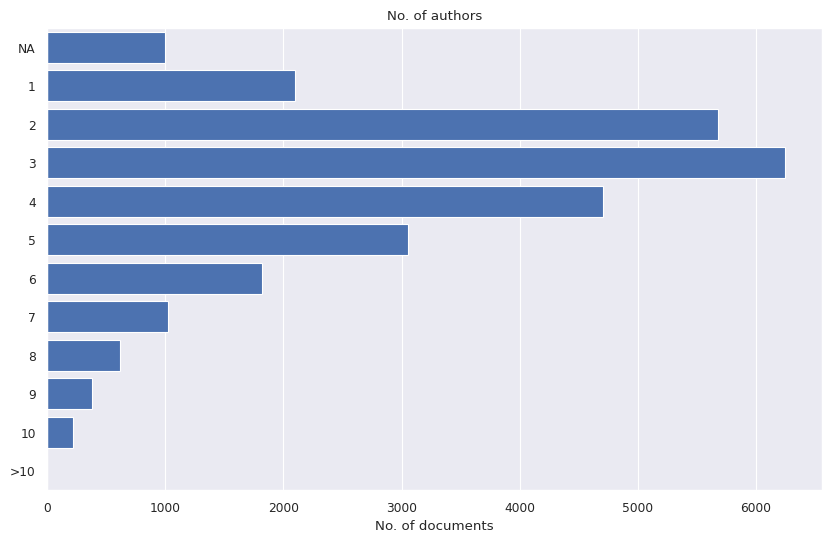

In [14]:
litstudy.plot_number_authors_histogram(docs);

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


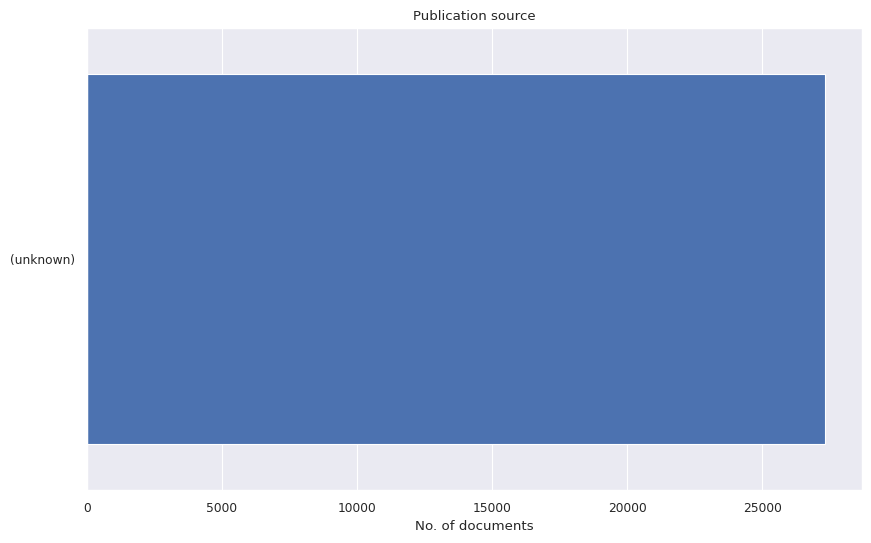

In [ ]:
# This names are long, which is why a short abbreviation is provided.
mapping = {
    "IEEE International parallel and distributed processing symposium IPDPS": "IEEE IPDPS",
    "IEEE International parallel and distributed processing symposium workshops IPDPSW": "IEEE IPDPS Workshops",
}

litstudy.plot_source_histogram(docs, mapper=mapping, limit=15);

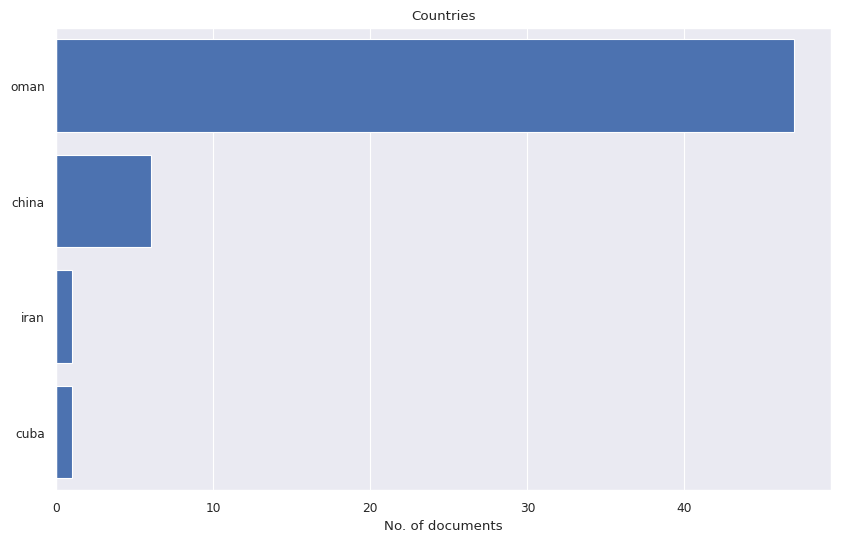

In [15]:
litstudy.plot_country_histogram(docs, limit=15);

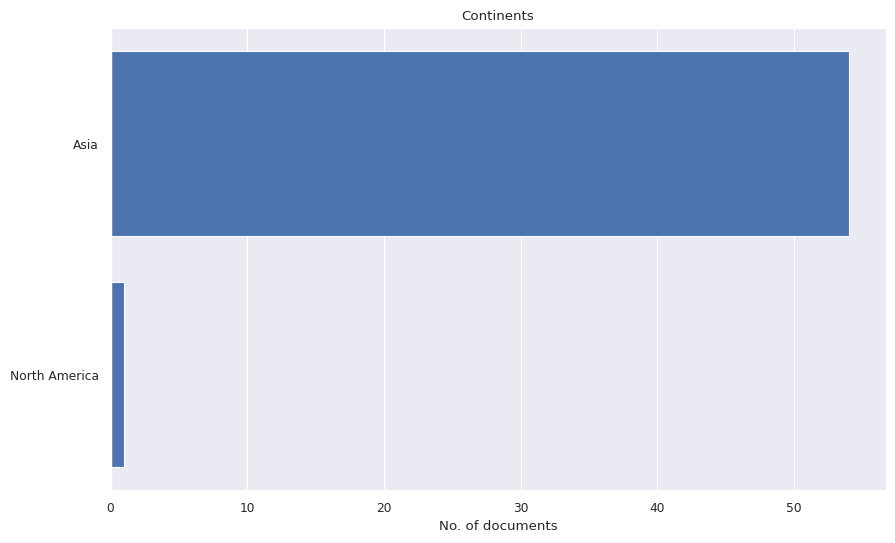

In [16]:
litstudy.plot_continent_histogram(docs);

## Network analysis

The network below shows an example of a co-citation network.
This is a type of network where nodes represent documents and edges represent pairs of documents that have been cited together simulatenously by other papers. The strength of the edges indicates how often two documents have been cited together.
Two papers with a high co-citation strength (i.e., stronger edge) are usually highly related.

In [17]:
from pyvis.network import Network
net = Network(notebook=True, cdn_resources='remote')

litstudy.plot_cocitation_network(docs_crossref)

citation.html


## Topic modeling

litstudy supports automatic topic discovery based on the words used in documents abstracts. We show an example below. First, we need to build a corpus from the document set. Note that `build_corpus` supports many arguments to tweak the preprocessing stage of building the corpus. In this example, we pass `ngram_threshold=0.85`. This argument adds commonly used n-grams (i.e., frequent consecutive words) to the corpus. For instance, `artificial` and `intelligence` is a bigram, so a token `artificial_intelligence` is added to the corpus.

In [ ]:
corpus = litstudy.build_corpus(docs, ngram_threshold=0.8)

We can compute a word distribution using `litstudy.compute_word_distribution` which shows how often each word occurs across all documents. In this example, we focus only on n-grams by selecting tokens that contain a `_`. We see that words such as `artificial intelligence` and `trade offs` indeed have been recognized as common bigrams.

In [ ]:
litstudy.compute_word_distribution(corpus).filter(like='_', axis=0).sort_index()

,count
anechoic_chamber,22
ant_colony,34
augmented_reality,43
base_station,165
circularly_polarized,83
...,...
thematic_mapper,19
trade_offs,66
unmanned_aerial,123
vice_versa,40


Let's visualize the word distribution from this corpus.

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


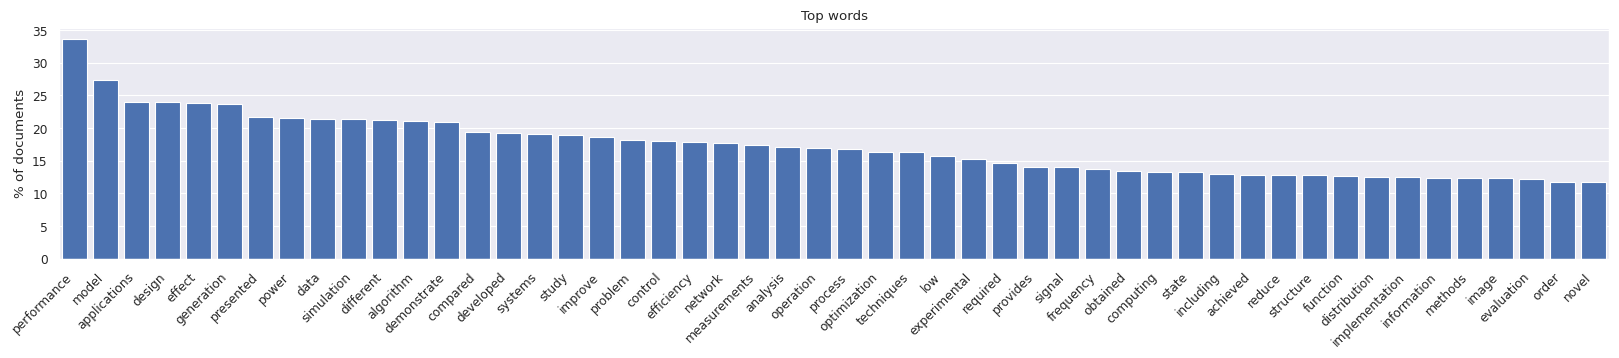

In [ ]:
plt.figure(figsize=(20, 3))
litstudy.plot_word_distribution(corpus, limit=50, title="Top words", vertical=True, label_rotation=45);

This word distribution looks normal. Next, we train an NMF topic model. Topic modeling is a technique from natural language processing for discovering abstract "topics" in a set of document. We need to manually select the number of desired topics. Here we choose 15 topics. It is recommended to experiment with more or less topics to obtain topics that are more fine-grained or more coarse-grained

In [ ]:
num_topics = 15
topic_model = litstudy.train_nmf_model(corpus, num_topics, max_iter=250)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/gensim/models/nmf.py:578: DeprecationWarning: Please import `csc_matrix` from the `scipy.sparse` namespace; the `scipy.sparse.csc` namespace is deprecated and will be removed in SciPy 2.0.0.
  if isinstance(corpus, scipy.sparse.csc.csc_matrix):
/usr/local/lib/python3.10/dist-packages/gensim/models/nmf.py:607: DeprecationWarning: Please import `csc_matrix` from the `scipy.sparse` namespace; the `scipy.sparse.csc` namespace is deprecated and will be removed in SciPy 2.0.0.
  if isinstance(corpus, scipy.sparse.csc.csc_matrix):
/usr/local/lib/python3.10/dist-packages/gensim/models/nmf.py:620: Deprecati

To understand the result of NMF, we can print the top 3 words for each topic.

In [ ]:
for i in range(num_topics):
    print(f'Topic {i+1}:', topic_model.best_tokens_for_topic(i))

Topic 1: ['algorithm', 'learning', 'optimization', 'problem', 'data']
Topic 2: ['antenna', 'array', 'band', 'ghz', 'radiation']
Topic 3: ['network', 'sensor', 'nodes', 'wireless', 'routing']
Topic 4: ['fiber', 'optical', 'laser', 'mode', 'wavelength']
Topic 5: ['power', 'wind', 'grid', 'energy', 'control']
Topic 6: ['robot', 'sensor', 'motion', 'human', 'tracking']
Topic 7: ['magnetic', 'motor', 'torque', 'machine', 'fault']
Topic 8: ['channel', 'receiver', 'mimo', 'signal', 'relay']
Topic 9: ['cover', 'inside', 'content', 'land', 'table']
Topic 10: ['cloud', 'service', 'security', 'technology', 'computing']
Topic 11: ['voltage', 'converter', 'switching', 'gate', 'circuit']
Topic 12: ['image', 'segmentation', 'resolution', 'detection', 'features']
Topic 13: ['control', 'stability', 'delay', 'systems', 'nonlinear']
Topic 14: ['gpu', 'parallel', 'programming', 'cpu', 'acceleration']
Topic 15: ['code', 'decoding', 'ldpc', 'video', 'bit']


An alternative way to visualize the output of NMF is to plot each discovered topic as a word cloud. The size of each word in a cloud indicate the importance of that word for that topic.

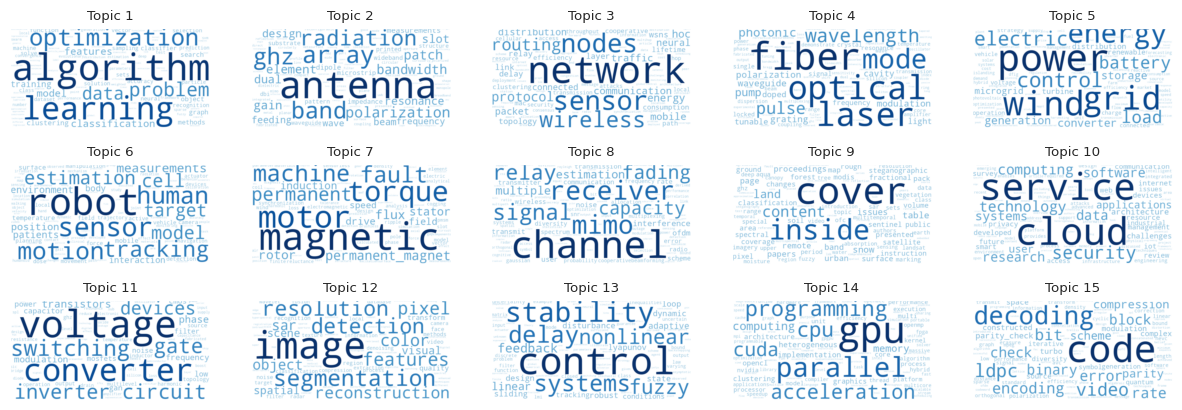

In [ ]:
plt.figure(figsize=(15, 5))
litstudy.plot_topic_clouds(topic_model, ncols=5);

These 15 topics look promising. For example, there is one topic on graphs, one on OpenACC (the open accelerators programming standard), one on OpenCL (the open compute language), one on FPGAs (field-programmable gate array), etc.

We can visualize the results as a "landscape" plot. This is a visual appealing way to place documents on 2D plane. The documents are placed such that similar documents are located closed to each other. However, this is a non-linear embedding so the distances between the documents are not linear.

In [ ]:
plt.figure(figsize=(20, 20))
litstudy.plot_embedding(corpus, topic_model);

KeyboardInterrupt: 

Error in callback <function _draw_all_if_interactive at 0x7c172d1424d0> (for post_execute):


KeyboardInterrupt: 

Error in callback <function flush_figures at 0x7c172d1411b0> (for post_execute):


KeyboardInterrupt: 

## Advanced topic modeling

We can combine the results of topic modeling with the plotting of statistics. Here we show we a simple example.

One of the topics appears to be on "deep_learning". First, we find the topic id for the topic that most strongly belongs to "deep_learning".

In [ ]:
topic_id = topic_model.best_topic_for_token('learning')

Let's print the top 10 papers that most stongly belong to this topic to check the results. We see that these are indeed documents on the topic of deep learning.

In [ ]:
for doc_id in topic_model.best_documents_for_topic(topic_id, limit=10):
    print(docs[int(doc_id)].title)

Behavior of Multiobjective Evolutionary Algorithms on Many-Objective Knapsack Problems
CAIM discretization algorithm
Local-Learning-Based Feature Selection for High-Dimensional Data Analysis
Cuckoo Search via Lévy flights
A New Dominance Relation-Based Evolutionary Algorithm for Many-Objective Optimization
Sparse evolutionary deep learning with over one million artificial neurons on commodity hardware
M-PAES: a memetic algorithm for multiobjective optimization
PDE: a Pareto-frontier differential evolution approach for multi-objective optimization problems
Using evolutionary algorithms as instance selection for data reduction in KDD: an experimental study
SemiBoost: Boosting for Semi-Supervised Learning


Next, we annotate the document set with a "dl_topic" tag for document that strongly belong to this topic (i.e., weight above a certain threshold).

After this, we define two groups: documents that have the tag "dl_topic" and documents that do not have this tag. Now we can, for instance, print the publications over the years to see if interest in deep learning has increased or decreased over the years.

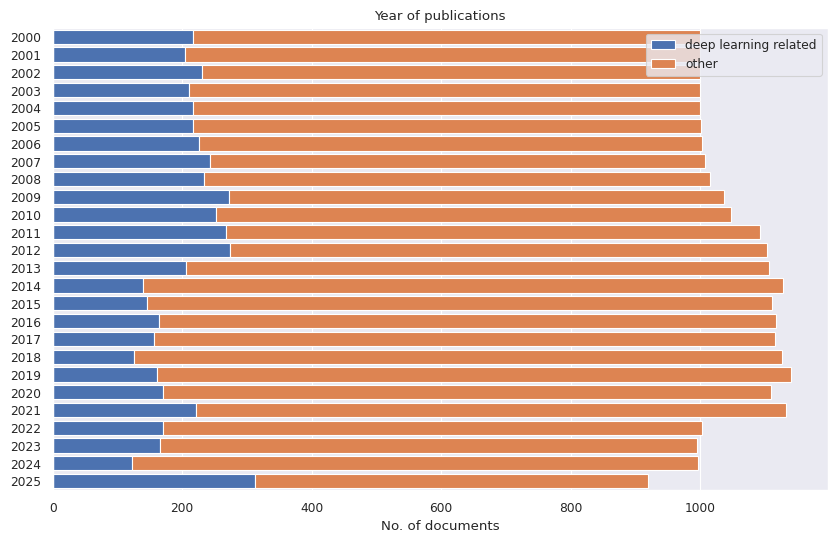

In [ ]:
threshold = 0.2
dl_topic = topic_model.doc2topic[:, topic_id] > threshold

docs = docs.add_property('dl_topic', dl_topic)


groups = {
    'deep learning related': 'dl_topic',
    'other': 'not dl_topic',
}

litstudy.plot_year_histogram(docs, groups=groups, stacked=True);

The histogram shows that interest in deep learning has clearly risen over the years. We can even calculate the exact amount by calculating the percentage of documents on deep learning each year. The example below shows that this percentage has increased from just 3.4% in 2011 to 13.6% in 2021.

In [ ]:
table = litstudy.compute_year_histogram(docs, groups=groups)
table.div(table.sum(axis=1), axis=0) * 100

,deep learning related,other
2000,21.600000,78.400000
2001,20.400000,79.600000
2002,23.100000,76.900000
2003,21.100000,78.900000
2004,21.600000,78.400000
2005,21.578422,78.421578
2006,22.532403,77.467597
2007,24.131082,75.868918
2008,22.933071,77.066929
2009,26.325940,73.674060


Alternatively, we can plot the two groups for the publications source. We can see that some journals/conferences have a strong focus on deep learning (e.g. "Neural Computing and Applications"), while others have no or few publications on deep learning (e.g. "Journal of Real Time Image Processing").

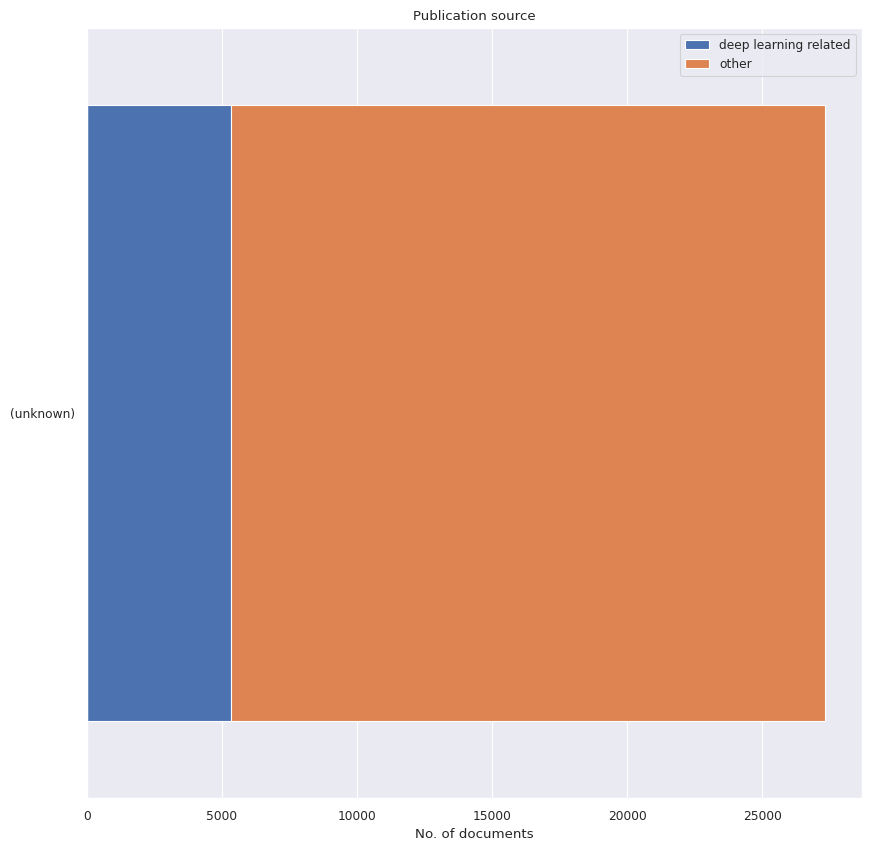

In [ ]:
plt.figure(figsize=(10, 10))
litstudy.plot_source_histogram(docs, groups=groups, limit=25, stacked=True);

We can even calculate the most popular publication venues for deep learning in our dataset using some simple Panda functions. It appears that "Neural Computing and Applications" is the most popular publication venue.

In [ ]:
# Compute histogram by publication venue
table = litstudy.compute_source_histogram(docs, groups=groups)

# Add column 'total'
table['total'] = table['deep learning related'] + table['other']

# Remove rare venues that have less than 5 publications
table = table[table['total'] >= 5]

# Add column 'ratio'
table['ratio'] = table['deep learning related'] / table['total'] * 100

# Sort by ratio in descending order
table.sort_values(by='ratio', ascending=False)

,deep learning related,other,total,ratio
(unknown),5326,21983,27309,19.502728


In [ ]:
from pyvis.network import Network
net = Network(notebook=True, cdn_resources='remote')

litstudy.plot_coupling_network(docs_crossref, max_edges=25000)

In [ ]:
# help for litstudy

help(litstudy)

Help on package litstudy:

NAME
    litstudy

PACKAGE CONTENTS
    clean
    common
    continent
    network
    nlp
    plot
    sources (package)
    stats
    stopwords
    types

CLASSES
    abc.ABC(builtins.object)
        litstudy.types.Affiliation
        litstudy.types.Author
        litstudy.types.Document
    builtins.object
        litstudy.types.DocumentIdentifier
        litstudy.types.DocumentSet
    
    class Affiliation(abc.ABC)
     |  Represents the affiliation of an author
     |  
     |  Method resolution order:
     |      Affiliation
     |      abc.ABC
     |      builtins.object
     |  
     |  Readonly properties defined here:
     |  
     |  city
     |      City the affiliation is located in.
     |  
     |  country
     |      Country the affiliation is located in.
     |  
     |  name
     |      Name of the affiliation
     |  
     |  ----------------------------------------------------------------------
     |  Data descriptors defined here:
     